In [22]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot as plt

In [20]:
# karas set up
# note: we use keras only for image data generation
from keras import backend as K
K.set_image_data_format('channels_last')
from keras.preprocessing.image import ImageDataGenerator

In [14]:
proj_root = os.path.abspath(os.path.join('../')) 
datadir = os.path.join(proj_root, 'data/labels/')

In [15]:
X1 = np.load(os.path.join(datadir, 'X-1.npy'))
Y1 = np.load(os.path.join(datadir, 'Y-1.npy'))

X2 = np.load(os.path.join(datadir, 'X-2.npy'))
Y2 = np.load(os.path.join(datadir, 'Y-2.npy'))


X = np.vstack((X1, X2))
Y = np.concatenate((Y1, Y2))

X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.5, stratify=Y, random_state=87)

pd.concat([pd.Series(Y_train).value_counts(),
           pd.Series(Y_test).value_counts()], axis=1)

,0,1
b'0',8,8
b'1',51,50
b'2',16,15
b'3',11,10
b'4',10,10
b'5',10,11
b'6',11,10
b'7',10,10
b'8',11,11
b'9',11,12


In [16]:
# Define preprocessor class for pipelining
class MyTrans:
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.reshape(X.shape[0], -1)

# quick test
a = X[0].flatten()
trans = MyTrans()
trans.fit(X)
b = trans.transform(X)[0]
np.all(a==b)

True

In [17]:
# Fit Gaussian Naive Bayes
pipe = Pipeline([
    ('flatten data to "obs*feature" shape', MyTrans()), 
    ('fit to gaussian naive bayes', GaussianNB())
])
fit = pipe.fit(X_train, Y_train)

print('train performance', fit.score(X_train, Y_train))
print('test performance', fit.score(X_test, Y_test))

train performance 1.0
test performance 1.0


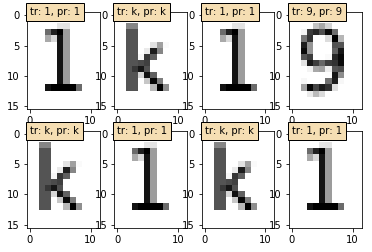

In [57]:
# observe prediction or random cases
def random_plot(X, y, predicted):
    indices = np.random.choice(len(X), 8)
    count = 0
    for i in indices:
        count += 1
        ax = plt.subplot(2, 4, count)
        ax.imshow(X[i], cmap='gray')
        ax.text(0, 0, 
                'tr: %s, pr: %s' % (y[i].decode('utf-8'), predicted[i].decode('utf-8')), \
                bbox={'facecolor':"wheat"})
    plt.show(block=False)

pred = fit.predict(X_test)
random_plot(X_test, Y_test, pred)
